In [43]:
import sys
sys.path.append('../')

from src.cmesrc.config import CMESRCV3_DB, PIXEL_BBOXES, SDOML_DATASET, GENERAL_DATASET, RESEARCH_LOG, ZARR_BASE_PATH, SDOML_TIMESTAMP_INFO
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import networkx as nx
import seaborn as sns
import zarr
from tqdm import tqdm
import pickle
import gc

In [44]:
# Check if SDOML dataset exists
if os.path.exists(SDOML_DATASET):
    os.remove(SDOML_DATASET)

# Create SDOML dataset as a copy of GENERAL_DATASET
os.system(f"cp {GENERAL_DATASET} {SDOML_DATASET}")


0

In [45]:
conn = sqlite3.connect(SDOML_DATASET)
cur = conn.cursor()

In [46]:
conn.execute("DROP TABLE IF EXISTS RAW_HARPS_PIXEL_BBOX;")

# Need to attach the pixel database
conn.execute("ATTACH DATABASE ? AS pixel_values", (PIXEL_BBOXES,))

# Now we need to find the pixel data for each image

conn.execute("""
CREATE TABLE main.RAW_HARPS_PIXEL_BBOX AS
                 SELECT PHPB.harpnum, PHPB.timestamp, PHPB.x_min, PHPB.x_max, PHPB.y_min, PHPB.y_max, PHPB.x_cen, PHPB.y_cen FROM pixel_values.HARPS_PIXEL_BBOX PHPB
                 """)

# Detach the old database

conn.execute("DETACH DATABASE pixel_values")
conn.commit()

In [47]:
try:
    cur.executescript("""
    ALTER TABLE HARPS ADD COLUMN pix_width INTEGER;
    ALTER TABLE HARPS ADD COLUMN pix_height INTEGER;
    """)
except sqlite3.OperationalError as e:
    if "duplicate column name" in str(e):
        pass
    else:
        raise e

cur.execute("DROP TABLE IF EXISTS temp_aggregate;")

conn.executescript("""
CREATE TEMP TABLE temp_aggregate AS
SELECT harpnum, MAX(x_max - x_min) as max_width, MAX(y_max - y_min) as max_height
FROM RAW_HARPS_PIXEL_BBOX
GROUP BY harpnum;

UPDATE HARPS
SET pix_width = (
SELECT max_width + ABS(max_width % 2 - 1)
FROM temp_aggregate
WHERE HARPS.harpnum = temp_aggregate.harpnum
),
pix_height = (
SELECT max_height + ABS(max_height % 2 - 1)
FROM temp_aggregate
WHERE HARPS.harpnum = temp_aggregate.harpnum
);

DROP TABLE temp_aggregate;

ALTER TABLE HARPS ADD COLUMN pix_area INTEGER;

UPDATE HARPS
SET pix_area = pix_width * pix_height;
""")

In [48]:
conn.execute("DROP TABLE IF EXISTS PROCESSED_HARPS_PIXEL_BBOX;")

# Then we need to update the values of x_min, x_max, y_min, y_max in PROCESSED_HARPS_PIXEL_BBOX

conn.executescript("""
                    CREATE TABLE IF NOT EXISTS PROCESSED_HARPS_PIXEL_BBOX AS
                    SELECT PHPB.harpnum, PHPB.timestamp, 
                    PHPB.x_cen - ((H.pix_width - 1) / 2) AS x_min,
                    PHPB.x_cen + ((H.pix_width - 1) / 2 + 1) AS x_max,
                    PHPB.y_cen - ((H.pix_height - 1) / 2) AS y_min,
                    PHPB.y_cen + ((H.pix_height - 1) / 2 + 1) AS y_max,
                    PHPB.x_cen, PHPB.y_cen
                    FROM RAW_HARPS_PIXEL_BBOX PHPB
                    INNER JOIN HARPS H
                    ON PHPB.harpnum = H.harpnum
                    """)

conn.commit()

In [49]:
cur.execute("DROP TABLE IF EXISTS temp_pixel_overlap")

cur.execute("""
CREATE TEMPORARY TABLE temp_pixel_overlap AS
SELECT
    a.harpnum AS harpnum1,
    b.harpnum AS harpnum2,
    a.timestamp AS timestamp,
    100.0 * CASE WHEN a.x_min < b.x_max AND a.x_max > b.x_min AND a.y_min < b.y_max AND a.y_max > b.y_min
        THEN ((MIN(a.x_max, b.x_max) - MAX(a.x_min, b.x_min)) * (MIN(a.y_max, b.y_max) - MAX(a.y_min, b.y_min)))
        ELSE 0
    END / (1.0 * H.pix_area) AS overlap_percent
FROM PROCESSED_HARPS_PIXEL_BBOX a
JOIN PROCESSED_HARPS_PIXEL_BBOX b ON a.timestamp = b.timestamp AND a.harpnum != b.harpnum
JOIN HARPS H ON H.harpnum = a.harpnum;
""")

cur.execute("DROP TABLE IF EXISTS avg_pixel_overlap")
cur.execute("DROP TABLE IF EXISTS PIXEL_OVERLAPS")

cur.executescript("""
CREATE TEMP TABLE avg_pixel_overlap AS
    SELECT tpo.harpnum1 as harpnum_a, tpo.harpnum2 as harpnum_b, AVG(tpo.overlap_percent) AS mean_overlap,
    (100.0 * (CASE WHEN COUNT(tpo.timestamp) > 1
             THEN (COUNT(tpo.timestamp) - 1)
             ELSE (COUNT(tpo.timestamp))
             END
             * 12.0 * 60.0) / (1.0 * NULLIF(strftime('%s', H.end) - strftime('%s', H.start), 0))) AS ocurrence_percentage
    FROM temp_pixel_overlap tpo
    JOIN HARPS H ON H.harpnum = tpo.harpnum1
    WHERE tpo.overlap_percent > 0
    GROUP BY harpnum1, harpnum2;

CREATE TABLE PIXEL_OVERLAPS AS
    SELECT ao.*,
    -- Standard deviation of the overlap
    SQRT(SUM((tpo.overlap_percent - ao.mean_overlap) * (tpo.overlap_percent - ao.mean_overlap)) / CASE WHEN COUNT(tpo.timestamp) > 1 THEN (COUNT(tpo.timestamp) - 1) ELSE 1 END) AS std_overlap
    FROM avg_pixel_overlap ao
    INNER JOIN temp_pixel_overlap tpo ON ao.harpnum_a = tpo.harpnum1 AND ao.harpnum_b = tpo.harpnum2
    GROUP BY harpnum_a, harpnum_b;
""")

conn.commit()

In [50]:
cur.execute("""
CREATE TABLE HOURLY_PIXEL_BBOX AS
SELECT * FROM PROCESSED_HARPS_PIXEL_BBOX PHPBB
WHERE strftime("%M", timestamp) IN ("00", "12", "24")
GROUP BY harpnum, strftime("%Y %m %d %H", timestamp)
""")

conn.commit()

In [51]:
df = pd.read_sql("""
WITH cme_info AS (
SELECT 
            PO.harpnum_a, 
            PO.harpnum_b,
            CASE WHEN MAX(FCHA.harpnum) IS NULL THEN 0 ELSE 1 END AS harpnum_a_cme,
            CASE WHEN MAX(FCHA2.harpnum) IS NULL THEN 0 ELSE 1 END AS harpnum_b_cme,
			mean_overlap,
			ocurrence_percentage

FROM PIXEL_OVERLAPS PO
LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA ON
PO.harpnum_a = FCHA.harpnum
LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA2 ON
PO.harpnum_b = FCHA2.harpnum
GROUP BY PO.harpnum_a, PO.harpnum_b)

SELECT * FROM cme_info
WHERE harpnum_a_cme != harpnum_b_cme
ORDER BY mean_overlap ASC
""", conn)

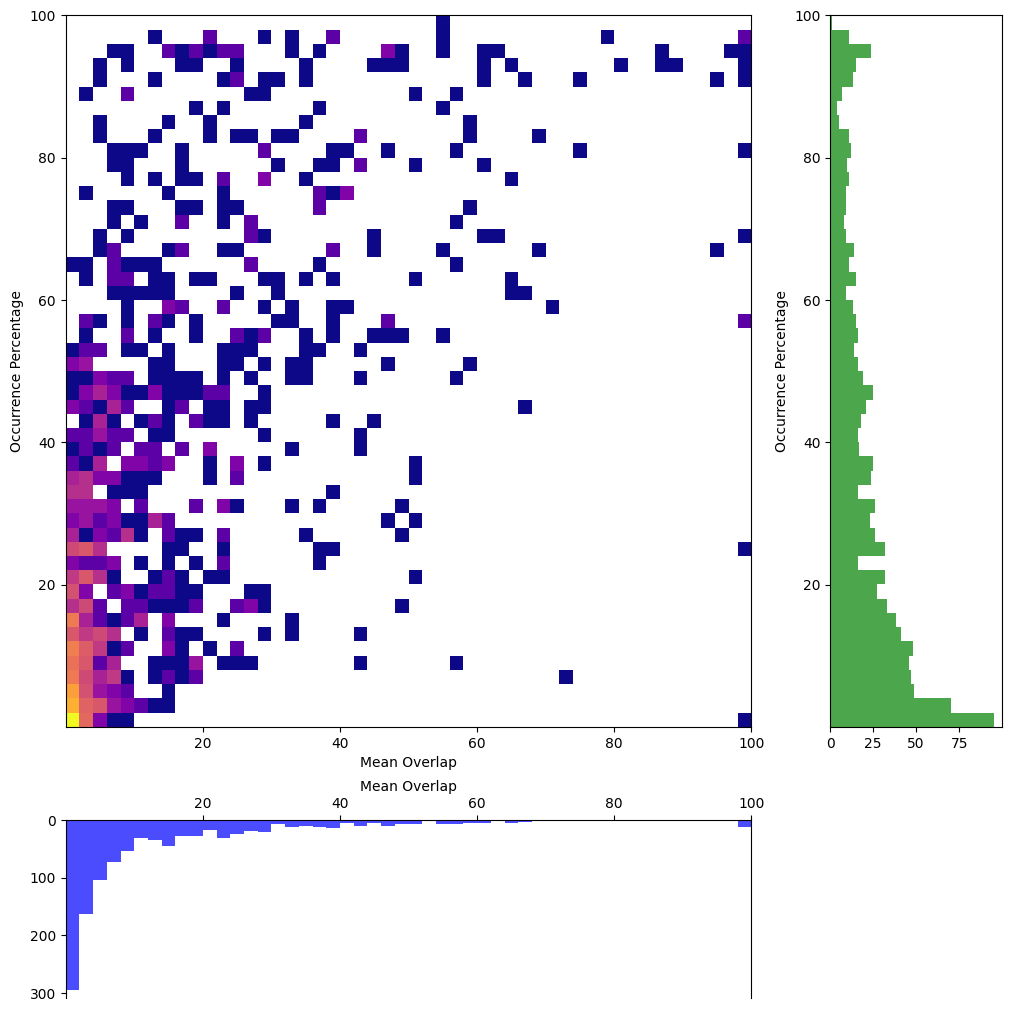

In [52]:
# Create main 2D histogram with aligned bins and limits
fig, ax = plt.subplots(2, 2, figsize=(10, 10),
                        gridspec_kw={'height_ratios': [4, 1], 'width_ratios': [4, 1]},
                        constrained_layout=True)

# Define common bins for alignment
bins = 50

# Main 2D histogram
hist2d = ax[0, 0].hist2d(df['mean_overlap'], df['ocurrence_percentage'], bins=bins, cmap='plasma', norm=LogNorm())
ax[0, 0].set_xlabel('Mean Overlap')
ax[0, 0].set_ylabel('Occurrence Percentage')

# Get the limits of the 2D histogram
x_min, x_max = ax[0, 0].get_xlim()
y_min, y_max = ax[0, 0].get_ylim()

# Inverted histogram for mean_overlap with aligned bins and limits
hist1d_bottom = ax[1, 0].hist(df['mean_overlap'], bins=hist2d[1], color='blue', alpha=0.7, range=(x_min, x_max))
ax[1, 0].xaxis.tick_top()  # Move x-axis ticks to top
ax[1, 0].xaxis.set_label_position('top')  # Move x-axis label to top
ax[1, 0].set_xlabel('Mean Overlap')
ax[1, 0].invert_yaxis()  # Invert the y-axis

# Move the x-axis line to the top
ax[1, 0].spines['bottom'].set_position(('outward', 10))
ax[1, 0].spines['top'].set_position(('outward', 0))
ax[1, 0].spines['bottom'].set_color('none')

ax[1,0].set_xlim(x_min, x_max)

# Histogram for ocurrence_percentage with aligned bins and limits
hist1d_side = ax[0, 1].hist(df['ocurrence_percentage'], bins=hist2d[2], color='green', alpha=0.7, orientation='horizontal', range=(y_min, y_max))
ax[0, 1].set_ylabel('Occurrence Percentage')

ax[0,1].set_ylim(y_min, y_max)

# Remove axis for the top-right subplot
ax[1, 1].axis('off')

plt.savefig("/home/julio/Downloads/mean_overlap_vs_ocurrence_percentage.svg")


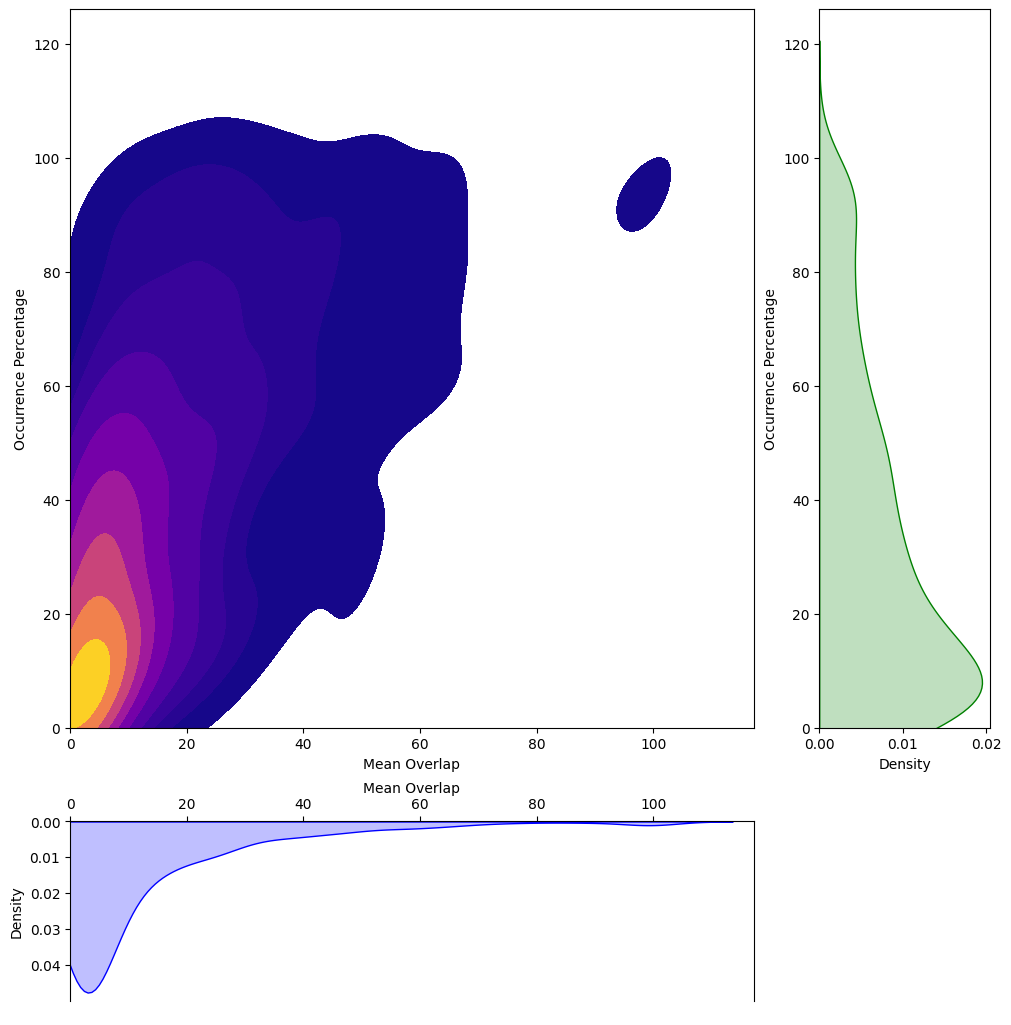

In [53]:
import seaborn as sns

# Create main 2D histogram with KDEs
fig, ax = plt.subplots(2, 2, figsize=(10, 10),
                        gridspec_kw={'height_ratios': [4, 1], 'width_ratios': [4, 1]},
                        constrained_layout=True)

# Main 2D KDE plot
sns.kdeplot(x=df['mean_overlap'], y=df['ocurrence_percentage'], cmap='plasma', ax=ax[0, 0], fill=True, clip=((0, None), (0, None)))
ax[0, 0].set_xlabel('Mean Overlap')
ax[0, 0].set_ylabel('Occurrence Percentage')

# Get the limits of the 2D KDE plot
x_min, x_max = ax[0, 0].get_xlim()
y_min, y_max = ax[0, 0].get_ylim()

# KDE for mean_overlap
sns.kdeplot(x=df['mean_overlap'], ax=ax[1, 0], fill=True, color='blue')
ax[1, 0].set_xlim(x_min, x_max)  # Align x-axis with main 2D plot
ax[1, 0].xaxis.tick_top()  # Move x-axis ticks to top
ax[1, 0].xaxis.set_label_position('top')  # Move x-axis label to top
ax[1, 0].set_xlabel('Mean Overlap')
ax[1, 0].invert_yaxis()  # Invert the y-axis

# Move the x-axis line to the top
ax[1, 0].spines['bottom'].set_position(('outward', 10))
ax[1, 0].spines['top'].set_position(('outward', 0))
ax[1, 0].spines['bottom'].set_color('none')

ax[1,0].set_xlim(x_min, x_max)

# KDE for ocurrence_percentage
sns.kdeplot(y=df['ocurrence_percentage'], ax=ax[0, 1], fill=True, color='green')
ax[0, 1].set_ylim(y_min, y_max)  # Align y-axis with main 2D plot
ax[0, 1].set_ylabel('Occurrence Percentage')

ax[0,1].set_ylim(y_min, y_max)

# Remove axis for the top-right subplot
ax[1, 1].axis('off')

plt.savefig("/home/julio/Downloads/mean_overlap_vs_ocurrence_percentage_kde.svg")


In [54]:
# Add columns harpnum_a_cme and harpnum_b_cme to PIXEL_OVERLAPS

try:
    cur.executescript("""
    ALTER TABLE PIXEL_OVERLAPS ADD COLUMN harpnum_a_cme INTEGER;
    ALTER TABLE PIXEL_OVERLAPS ADD COLUMN harpnum_b_cme INTEGER;
    """)
# Maybe they already exist
except sqlite3.OperationalError:
    pass

cur.execute("""
WITH cme_info AS (
SELECT 
            PO.harpnum_a, 
            PO.harpnum_b,
            CASE WHEN MAX(FCHA.harpnum) IS NULL THEN 0 ELSE 1 END AS harpnum_a_cme,
            CASE WHEN MAX(FCHA2.harpnum) IS NULL THEN 0 ELSE 1 END AS harpnum_b_cme,
			mean_overlap,
			ocurrence_percentage

FROM PIXEL_OVERLAPS PO
LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA ON
PO.harpnum_a = FCHA.harpnum
LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA2 ON
PO.harpnum_b = FCHA2.harpnum
GROUP BY PO.harpnum_a, PO.harpnum_b)

UPDATE PIXEL_OVERLAPS
SET harpnum_a_cme = (
SELECT harpnum_a_cme FROM cme_info
WHERE PIXEL_OVERLAPS.harpnum_a = cme_info.harpnum_a AND PIXEL_OVERLAPS.harpnum_b = cme_info.harpnum_b
),
harpnum_b_cme = (
SELECT harpnum_b_cme FROM cme_info
WHERE PIXEL_OVERLAPS.harpnum_a = cme_info.harpnum_a AND PIXEL_OVERLAPS.harpnum_b = cme_info.harpnum_b
)
            """)

conn.commit()

In [55]:
cur.execute("DROP TABLE IF EXISTS ignore_harps")
cur.execute("""
CREATE TEMP TABLE ignore_harps AS
    SELECT 
       CASE 
           WHEN harpnum_a_cme THEN harpnum_b 
           ELSE harpnum_a 
       END AS to_ignore 
FROM PIXEL_OVERLAPS
WHERE harpnum_a_cme != harpnum_b_cme 
  AND mean_overlap > 30 
  AND ocurrence_percentage > 30
ORDER BY harpnum_a, harpnum_b ASC;
""") 

In [56]:
# So now lets look at the distribution of areas of the pixel boxes

df = pd.read_sql("""
WITH SELECTED_HARPS AS (
                 SELECT DISTINCT harpnum FROM HOURLY_PIXEL_BBOX
)
SELECT 
                 *,
                 CASE WHEN FCHA.cme_id IS NULL THEN 0 ELSE 1 END AS has_cme
FROM HARPS
LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA ON HARPS.harpnum = FCHA.harpnum
INNER JOIN SELECTED_HARPS SH ON HARPS.harpnum = SH.harpnum
WHERE HARPS.pix_area IS NOT NULL
GROUP BY HARPS.harpnum
""", conn)

df["norm_pix_area"] = 100 * df["pix_area"] / (100 * 100)

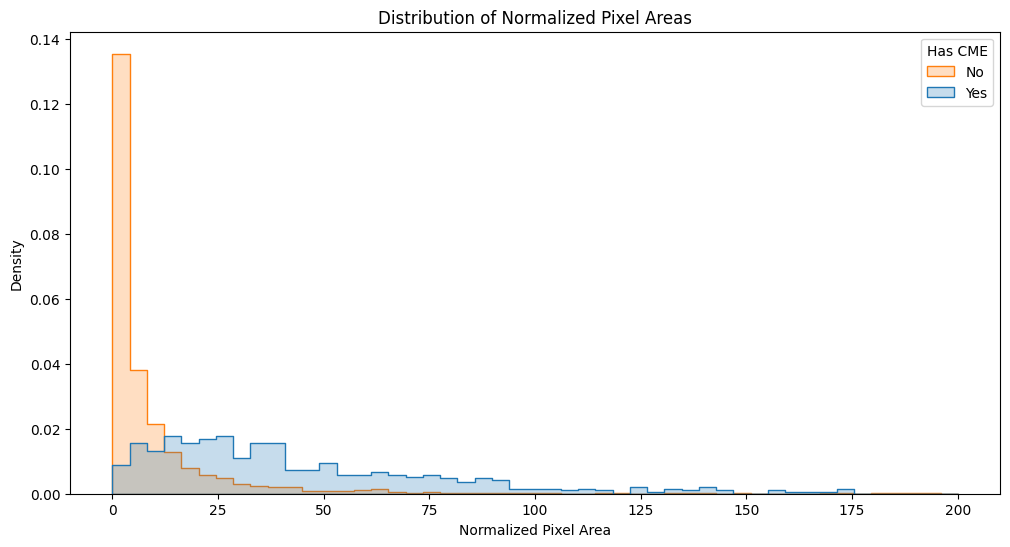

In [57]:
# Plotting
# Set up the matplotlib figure

fig, ax = plt.subplots(figsize=(12, 6))


hist_bins = np.linspace(0, 200, 50)

# Generate histograms using seaborn for better styling

sns.histplot(df, x="norm_pix_area", hue="has_cme", element="step", stat="density", common_norm=False, bins=hist_bins, ax=ax, hue_order=[1,0])



# Customize the plot

ax.set_title('Distribution of Normalized Pixel Areas')

ax.set_xlabel('Normalized Pixel Area')

ax.set_ylabel('Density')

ax.legend(title='Has CME', labels=['No', 'Yes'])



# Show the plot


plt.savefig(f"{RESEARCH_LOG}/content/images/2023/10/02/pixel_area_distribution.svg")

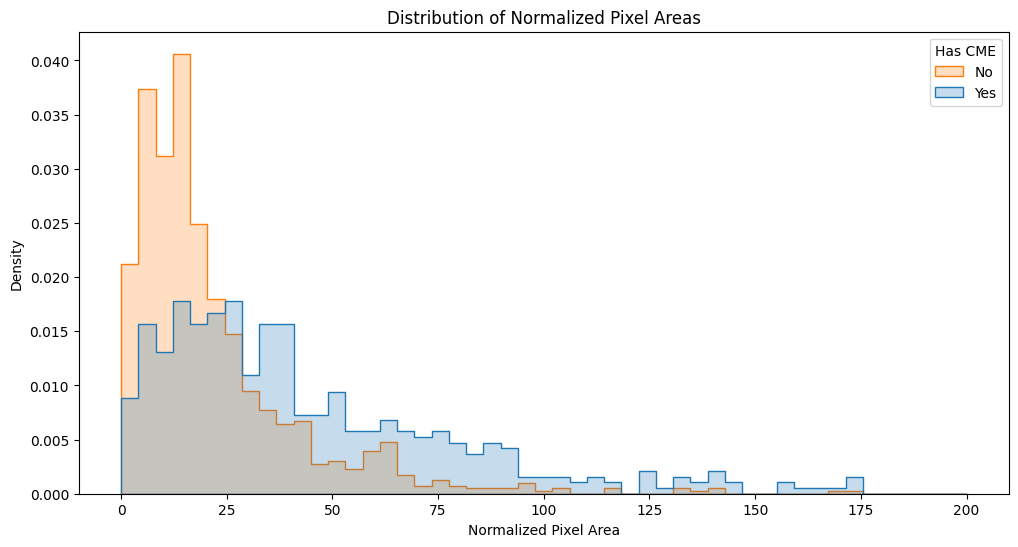

In [58]:
# Create bins for the 'No CME' data based on 'norm_pix_area'
labels = range(len(hist_bins) - 1)
df['bin'] = pd.cut(df['norm_pix_area'], bins=hist_bins, labels=labels)

# Separate 'Yes CME' and 'No CME' data
df_yes = df[df['has_cme'] == 1]
df_no = df[df['has_cme'] == 0]

df_yes_cme_counts = df_yes['bin'].value_counts()
df_no_cme_counts = df_no['bin'].value_counts()
# Assume df_yes_cme_counts and df_no_cme_counts are the counts of 'Yes CME' and 'No CME' in each bin
# You can get this information using something like df[df['has_cme'] == 1]['bin'].value_counts()

# Calculate the desired number of 'No CME' in each bin based on the 'Yes CME' distribution
desired_no_cme_counts =  5 * df_yes_cme_counts  # Or some other criteria

# Calculate frac for each bin
frac_per_bin = desired_no_cme_counts / df_no_cme_counts

# Clip the frac values to be between 0 and 1
frac_per_bin = frac_per_bin.clip(0, 1)
frac_per_bin.replace(np.nan, 1, inplace=True)

# Perform stratified sampling
sampled_df_no = df_no.groupby('bin').apply(lambda x: x.sample(frac=frac_per_bin.get(x.name, 1)))

# Remove index level added by groupby and sampling
sampled_df_no.reset_index(drop=True, inplace=True)

# Concatenate the sampled 'No CME' data with the 'Yes CME' data to get the balanced dataset
df_balanced = pd.concat([df_yes, sampled_df_no])

# Remove the 'bin' column as it's no longer needed
df_balanced.drop(columns=['bin'], inplace=True)

df_balanced.reset_index(drop=True, inplace=True)


# Plotting
# Set up the matplotlib figure

fig, ax = plt.subplots(figsize=(12, 6))



# Generate histograms using seaborn for better styling

sns.histplot(df_balanced, x="norm_pix_area", hue="has_cme", element="step", stat="density", common_norm=False, bins=hist_bins, ax=ax, hue_order=[1,0])



# Customize the plot

ax.set_title('Distribution of Normalized Pixel Areas')

ax.set_xlabel('Normalized Pixel Area')

ax.set_ylabel('Density')

ax.legend(title='Has CME', labels=['No', 'Yes'])



# Show the plot

plt.savefig(f"{RESEARCH_LOG}/content/images/2023/10/02/adjusted_pixel_area_distribution.svg")

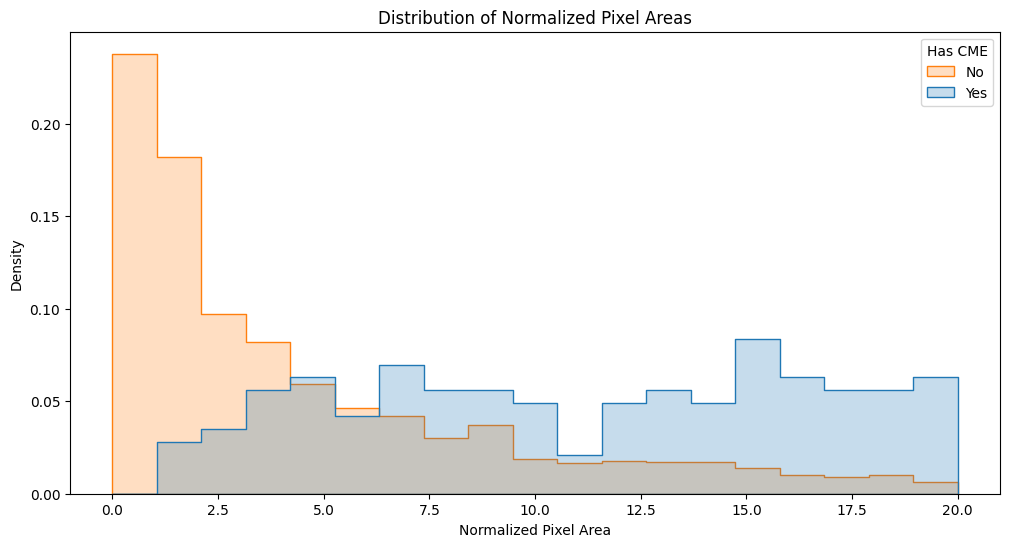

In [59]:
# Let's focus now only on the 0-10 range

bins = np.linspace(0, 20, 20)

# Plotting

# Set up the matplotlib figure

fig, ax = plt.subplots(figsize=(12, 6))

# Generate histograms using seaborn for better styling

sns.histplot(df, x="norm_pix_area", hue="has_cme", element="step", stat="density", common_norm=False, bins=bins, ax=ax, hue_order=[1,0])

# Customize the plot

ax.set_title('Distribution of Normalized Pixel Areas')
ax.set_xlabel('Normalized Pixel Area')
ax.set_ylabel('Density')
ax.legend(title='Has CME', labels=['No', 'Yes'])

plt.savefig(f"{RESEARCH_LOG}/content/images/2023/10/02/pixel_area_distribution_0_20.svg")

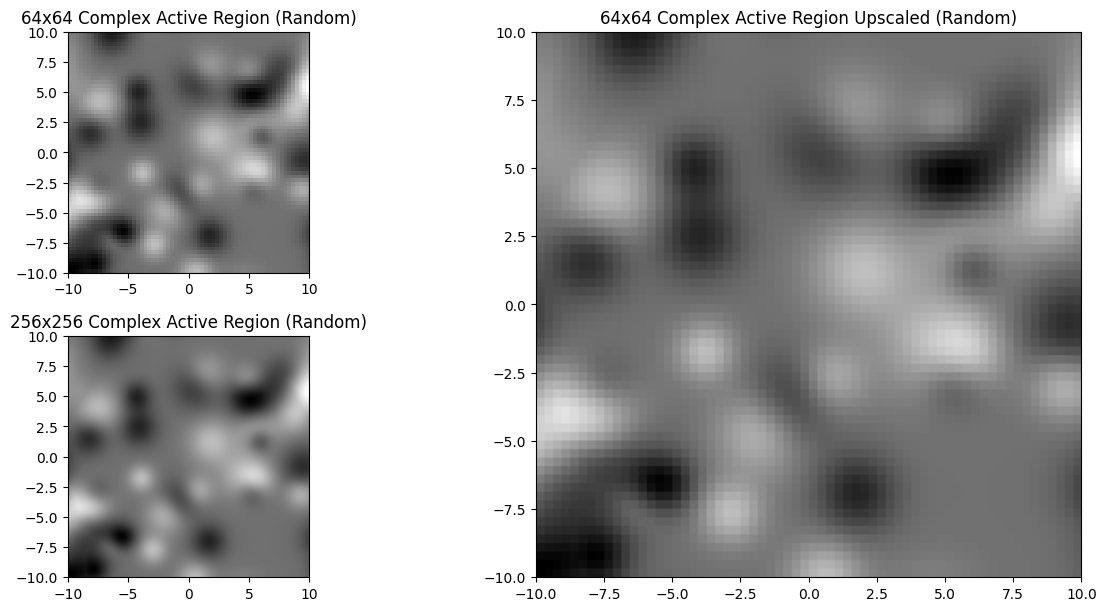

In [60]:
from scipy.ndimage import rotate
import random

random.seed(42)

def complex_active_region_field_random(X, Y, num_dipoles=5):

    Z = np.zeros_like(X)

    

    for _ in range(num_dipoles):

        x0 = random.uniform(-8, 8)

        y0 = random.uniform(-8, 8)

        a = random.uniform(0.2, 1)

        strength = random.choice([1, -1])

        rotation = random.uniform(0, 360)

        

        Z_temp = strength * np.exp(-((X - x0)**2 + (Y - y0)**2) / a)

        Z_temp_rot = rotate(Z_temp, rotation, reshape=False, mode='nearest')

        Z += Z_temp_rot



    return Z

SMALL_RESOLUTION = 64

if 512 % SMALL_RESOLUTION != 0:
    raise ValueError("The SMALL_RESOLUTION must be a factor of 512")

DOWNSCALE = int(512 // SMALL_RESOLUTION)
UPSCALE = int(DOWNSCALE / 2)

# Generate the 512x512 pixel image using the complex active region magnetic field function
# Use an even larger domain for X and Y, from -10 to 10
x_512 = np.linspace(-5, 5, 512)
y_512 = np.linspace(-5, 5, 512)
X_512, Y_512 = np.meshgrid(x_512, y_512)

# Generate the 512x512 pixel image using the random parameter generation
Z_512_random = complex_active_region_field_random(X_512, Y_512, num_dipoles=100)

# Downsample the 512x512 image to 256x256 and 32x32
Z_256_random = Z_512_random[::2, ::2]
Z_32_random = Z_512_random[::DOWNSCALE, ::DOWNSCALE]

# Upscale the 32x32 image to 256x256 using nearest-neighbor interpolation
Z_upscaled_32_random = np.kron(Z_32_random, np.ones((UPSCALE, UPSCALE)))

# Create plots using plt.subplot_mosaic for the custom layout
layout = [['top_left', 'right'],
          ['bottom_left', 'right']]

fig, axd = plt.subplot_mosaic(layout, figsize=(12, 6), constrained_layout=True)

# Top-left: 32x32 image
axd['top_left'].imshow(Z_32_random, cmap='gray', origin='lower', extent=[-10, 10, -10, 10])
axd['top_left'].set_title(f"{SMALL_RESOLUTION}x{SMALL_RESOLUTION} Complex Active Region (Random)")

# Bottom-left: 256x256 image
axd['bottom_left'].imshow(Z_256_random, cmap='gray', origin='lower', extent=[-10, 10, -10, 10])
axd['bottom_left'].set_title("256x256 Complex Active Region (Random)")

# Right: 32x32 image upscaled to 256x256
axd['right'].imshow(Z_upscaled_32_random, cmap='gray', origin='lower', extent=[-10, 10, -10, 10])
axd['right'].set_title(f"{SMALL_RESOLUTION}x{SMALL_RESOLUTION} Complex Active Region Upscaled (Random)")

# save as a nice svg

plt.savefig(f"{RESEARCH_LOG}/content/images/2023/10/02/complex_active_region_2_{SMALL_RESOLUTION}.svg", dpi=300)

In [61]:
df["eq_side"] = np.sqrt(df["pix_area"])

df["big_enough"] = df["eq_side"] > 16

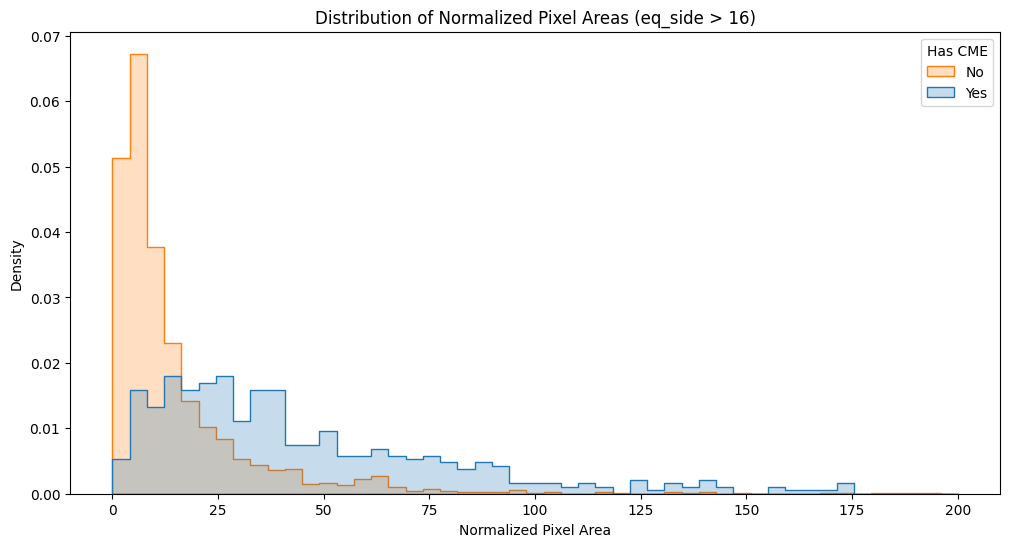

In [62]:
# Plotting
# Set up the matplotlib figure

fig, ax = plt.subplots(figsize=(12, 6))


hist_bins = np.linspace(0, 200, 50)

# Generate histograms using seaborn for better styling

sns.histplot(df[df["big_enough"]], x="norm_pix_area", hue="has_cme", element="step", stat="density", common_norm=False, bins=hist_bins, ax=ax, hue_order=[1,0])



# Customize the plot

ax.set_title('Distribution of Normalized Pixel Areas (eq_side > 16)')

ax.set_xlabel('Normalized Pixel Area')

ax.set_ylabel('Density')

ax.legend(title='Has CME', labels=['No', 'Yes'])



# Show the plot


plt.savefig(f"{RESEARCH_LOG}/content/images/2023/10/02/pixel_area_distribution_eq_side_plus_16.svg")

In [63]:
summary = pd.read_sql("""
WITH SELECTED_HARPS AS (
    SELECT DISTINCT harpnum FROM HOURLY_PIXEL_BBOX
)
SELECT 
    H.*,
    CASE WHEN FCHA.harpnum IS NULL THEN 0 ELSE 1 END AS has_cme,
    CASE WHEN ih.to_ignore IS NULL THEN 0 ELSE 1 END AS overlap_rejected,
    CASE WHEN H.pix_area > 256 THEN 1 ELSE 0 END AS big_enough
FROM HARPS H
INNER JOIN SELECTED_HARPS SH ON H.harpnum = SH.harpnum
LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA ON H.harpnum = FCHA.harpnum
LEFT JOIN ignore_harps ih ON H.harpnum = ih.to_ignore
WHERE H.pix_area IS NOT NULL
GROUP BY H.harpnum
""", conn)

cme_rejected_overlap = len(summary[(summary["has_cme"] == 1) & (summary["overlap_rejected"] == 1)])
cme_rejected_size = len(summary[(summary["has_cme"] == 1) & (summary["big_enough"] == 0) & (summary["overlap_rejected"] == 0)])
cme_accepted = len(summary[(summary["has_cme"] == 1) & (summary["big_enough"] == 1) & (summary["overlap_rejected"] == 0)])
total_cme = len(summary[summary["has_cme"] == 1])

assert cme_rejected_overlap + cme_rejected_size + cme_accepted == total_cme

no_cme_rejected_overlap = len(summary[(summary["has_cme"] == 0) & (summary["overlap_rejected"] == 1)])
no_cme_rejected_size = len(summary[(summary["has_cme"] == 0) & (summary["big_enough"] == 0) & (summary["overlap_rejected"] == 0)])
no_cme_accepted = len(summary[(summary["has_cme"] == 0) & (summary["big_enough"] == 1) & (summary["overlap_rejected"] == 0)])
total_no_cme = len(summary[summary["has_cme"] == 0])

assert no_cme_rejected_overlap + no_cme_rejected_size + no_cme_accepted == total_no_cme

# Now build pd dataframe with columns Overlap Rejected, Size Rejected, Accepted, Total and rows CME, No CME, Total

df = pd.DataFrame(columns=["Overlap Rejected", "Size Rejected", "Accepted", "Total"], index=["CME", "No CME", "Total"])

df.loc["CME", "Overlap Rejected"] = cme_rejected_overlap
df.loc["CME", "Size Rejected"] = cme_rejected_size
df.loc["CME", "Accepted"] = cme_accepted
df.loc["CME", "Total"] = total_cme

df.loc["No CME", "Overlap Rejected"] = no_cme_rejected_overlap
df.loc["No CME", "Size Rejected"] = no_cme_rejected_size
df.loc["No CME", "Accepted"] = no_cme_accepted
df.loc["No CME", "Total"] = total_no_cme

df.loc["Total", "Overlap Rejected"] = cme_rejected_overlap + no_cme_rejected_overlap
df.loc["Total", "Size Rejected"] = cme_rejected_size + no_cme_rejected_size
df.loc["Total", "Accepted"] = cme_accepted + no_cme_accepted
df.loc["Total", "Total"] = total_cme + total_no_cme

df.to_markdown(f"{RESEARCH_LOG}/content/images/2023/10/02/summary_table.md")

In [64]:
cur.execute("DROP TABLE IF EXISTS ACCEPTED_HARPS")
cur.execute("""
CREATE TABLE ACCEPTED_HARPS AS
            SELECT DISTINCT H.harpnum FROM HARPS H
            INNER JOIN HOURLY_PIXEL_BBOX HPB ON H.harpnum = HPB.harpnum
            LEFT JOIN ignore_harps ih ON H.harpnum = ih.to_ignore
            WHERE H.pix_area > 256 AND ih.to_ignore IS NULL
""")

conn.commit()

In [65]:
try:
    cur.execute("ALTER TABLE HOURLY_PIXEL_BBOX ADD COLUMN zarr_index INTEGER;")
except sqlite3.OperationalError as e:
    if "duplicate column name: zarr_index" == str(e):
        pass
    else:
        raise e

# Select all harpnums
cur.execute("""
SELECT DISTINCT harpnum FROM HOURLY_PIXEL_BBOX
""")

harpnums = cur.fetchall()

# Create index for harpnum, index for 
# faster access

cur.execute("""
CREATE INDEX IF NOT EXISTS idx_hourly_pixel_bbox_harpnum_timestamp ON PROCESSED_HARPS_PIXEL_BBOX (harpnum, timestamp)
""")

cur.execute("DROP TABLE IF EXISTS temp_zarr_index")
cur.execute("""
CREATE TEMP TABLE temp_zarr_index (
    harpnum INTEGER,
    timestamp TEXT,
    zarr_index INTEGER
)
            """)

# Now we go through each harpnum and find the zarr index for each timestamp
for harpnum in tqdm(harpnums, desc="Finding zarr index", unit="harpnum"):
    harpnum = harpnum[0]

    # Open the zarr DirectoryStore
    zarr_path = os.path.join(ZARR_BASE_PATH, f"{harpnum}")

    zarr_store = zarr.DirectoryStore(zarr_path)

    # Open the zarr

    try:
        root = zarr.open(zarr_store, mode='r')
    except:
        print(f"Could not open zarr for harpnum {harpnum}")
        print(zarr_path)
        continue

    # Get the timestamps from the zarr group
    attrs = root.attrs.asdict()

    timestamps = attrs["timestamps"]

    # Now we need to update each entry in the table with the zarr index

    for i, timestamp in enumerate(timestamps):
        cur.execute("""
        INSERT INTO temp_zarr_index (harpnum, timestamp, zarr_index) VALUES (?, ?, ?)
                    """, (harpnum, timestamp, i))
    
cur.execute("CREATE INDEX IF NOT EXISTS idx_temp_zarr_index_harpnum_timestamp ON temp_zarr_index (harpnum, timestamp)")
cur.execute("""
UPDATE HOURLY_PIXEL_BBOX
SET zarr_index = (
SELECT temp_zarr_index.zarr_index
FROM temp_zarr_index
WHERE HOURLY_PIXEL_BBOX.harpnum = temp_zarr_index.harpnum AND HOURLY_PIXEL_BBOX.timestamp = temp_zarr_index.timestamp
)
""")

conn.commit()

# Check no image is missing

cur.execute("""
SELECT COUNT(*) FROM HOURLY_PIXEL_BBOX
WHERE zarr_index IS NULL
""")

if cur.fetchone()[0] != 0:
    raise ValueError("There are missing images")

Finding zarr index: 100%|██████████| 3548/3548 [00:01<00:00, 2109.65harpnum/s]


In [66]:
# Need to read the SDOML image data
cur.execute("DROP TABLE IF EXISTS IMAGES")
cur.execute("""
CREATE TABLE IMAGES (
  timestamp TEXT NOT NULL UNIQUE,                 -- Unique timestamp for each image
  year INTEGER NOT NULL,                          -- Year the image was captured
  month INTEGER NOT NULL,                         -- Month the image was captured
  day INTEGER NOT NULL,                           -- Day of the month the image was captured
  hour INTEGER NOT NULL,                          -- Hour of the day the image was captured
  minute INTEGER NOT NULL,                        -- Minute of the hour the image was captured
  second INTEGER NOT NULL,                        -- Second of the minute the image was captured
  idx INTEGER NOT NULL                            -- Index to access the image in the zarr format
);
""")


with open(SDOML_TIMESTAMP_INFO, "rb") as f:
    sdoml_timestamp_info = pickle.load(f)

timestamps = list(sdoml_timestamp_info.keys())
indices = [entry["index"] for entry in sdoml_timestamp_info.values()]

i = 0
years = []
months = []
days = []
hours = []
minutes = []
seconds = []
for timestamp in timestamps:
    # Get the year, month, day, hour, minute and seconds from the timestamp
    year = int(timestamp[:4])
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])

    years.append(year)
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)
    seconds.append(second)

new_data = [(timestamp, year, month, day, hour, minute, second, idx) for timestamp, year, month, day, hour, minute, second, idx in zip(timestamps, years, months, days, hours, minutes, seconds, indices)]

cur.executemany("INSERT INTO IMAGES (timestamp, year, month, day, hour, minute, second, idx) VALUES (?, ?, ?, ?, ?, ?, ?, ?) ON CONFLICT(timestamp) DO NOTHING", new_data)
conn.commit()

del sdoml_timestamp_info, timestamps, indices, years, months, days, hours, minutes, seconds, new_data
gc.collect()

0

In [67]:
cur.executescript("""
DROP TABLE IF EXISTS slice_img_counts;
DROP TABLE IF EXISTS SDOML_DATASET;
""")

cur.executescript("""
CREATE TEMP TABLE slice_img_counts AS
SELECT slice_id, COUNT(*) AS img_count, MIN( zarr_index ) AS start_index, MAX( zarr_index ) AS end_index, MIN(timestamp) AS start_image, MAX(timestamp) AS end_image
FROM GENERAL_DATASET
INNER JOIN HOURLY_PIXEL_BBOX HPB ON GENERAL_DATASET.harpnum = HPB.harpnum AND GENERAL_DATASET.obs_start <= HPB.timestamp AND GENERAL_DATASET.obs_end >= HPB.timestamp
GROUP BY slice_id;

CREATE TABLE SDOML_DATASET AS
SELECT GD.*, SIC.img_count, SIC.start_index, SIC.end_index, SIC.start_image, SIC.end_image, SIC.img_count as img_count
FROM GENERAL_DATASET GD
INNER JOIN slice_img_counts SIC ON GD.slice_id = SIC.slice_id
INNER JOIN ACCEPTED_HARPS AH ON GD.harpnum = AH.harpnum
WHERE 
SIC.img_count = 24 OR
(SIC.img_count = 23 AND ((strftime(GD.obs_end) - strftime(SIC.end_image)) / 60.0) <= 30)
""")

conn.commit()

In [113]:
cur.execute("""
SELECT COUNT(DISTINCT (harpnum || cme_id)) FROM SDOML_DATASET
            """)

n_harpnum_cme_pairs = cur.fetchone()[0]

# Now with GENERAL_DATASET

cur.execute("""
SELECT COUNT(DISTINCT (harpnum || cme_id)) FROM GENERAL_DATASET
            """)

n_harpnum_cme_pairs_gd = cur.fetchone()[0]

cur.execute("""
WITH has_cme AS (
SELECT harpnum, MAX(cme_id) as cme_id FROM SDOML_DATASET GROUP BY harpnum
)
SELECT COUNT(DISTINCT harpnum) FROM has_cme
WHERE cme_id IS NOT NULL
""")

n_harpnum_with_cme = cur.fetchone()[0]

# Now with GENERAL_DATASET

cur.execute("""
WITH has_cme AS (
SELECT harpnum, MAX(cme_id) as cme_id FROM GENERAL_DATASET GROUP BY harpnum
)
SELECT COUNT(DISTINCT harpnum) FROM has_cme
WHERE cme_id IS NOT NULL
""")

n_harpnum_with_cme_gd = cur.fetchone()[0]

cur.execute("""
WITH has_cme AS (
SELECT harpnum, MAX(cme_id) as cme_id FROM SDOML_DATASET GROUP BY harpnum
)
SELECT COUNT(DISTINCT harpnum) FROM has_cme
WHERE cme_id IS NULL
""")

n_harpnum_without_cme = cur.fetchone()[0]

# Now with GENERAL_DATASET

cur.execute("""
WITH has_cme AS (
SELECT harpnum, MAX(cme_id) as cme_id FROM GENERAL_DATASET GROUP BY harpnum
)
SELECT COUNT(DISTINCT harpnum) FROM has_cme
WHERE cme_id IS NULL
""")

n_harpnum_without_cme_gd = cur.fetchone()[0]

cur.execute("""
SELECT COUNT(*) FROM SDOML_DATASET
WHERE label=1
""")

n_positive_rows = cur.fetchone()[0]

# Now with GENERAL_DATASET

cur.execute("""
SELECT COUNT(*) FROM GENERAL_DATASET
WHERE label=1
""")

n_positive_rows_gd = cur.fetchone()[0]

cur.execute("""
SELECT COUNT(*) FROM SDOML_DATASET
WHERE label=0
""")

n_negative_rows = cur.fetchone()[0]

# Now with GENERAL_DATASET

cur.execute("""
SELECT COUNT(*) FROM GENERAL_DATASET
WHERE label=0
""")

n_negative_rows_gd = cur.fetchone()[0]

In [115]:
print(f"""
Total number of harpnum-cme_id pairs: {n_harpnum_cme_pairs} (c.f. {n_harpnum_cme_pairs_gd})
Number of harpnums with CME: {n_harpnum_with_cme} (c.f. {n_harpnum_with_cme_gd})
Number of harpnums without CME: {n_harpnum_without_cme} (c.f. {n_harpnum_without_cme_gd})

Number of positive rows: {n_positive_rows} (c.f. {n_positive_rows_gd})
Number of negative rows: {n_negative_rows} (c.f. {n_negative_rows_gd})

Imbalance ratio: {n_negative_rows / n_positive_rows} (c.f. {n_negative_rows_gd / n_positive_rows_gd})
""")


Total number of harpnum-cme_id pairs: 350 (c.f. 411)
Number of harpnums with CME: 281 (c.f. 325)
Number of harpnums without CME: 1633 (c.f. 3226)

Number of positive rows: 21754 (c.f. 27837)
Number of negative rows: 232464 (c.f. 345586)

Imbalance ratio: 10.686034752229475 (c.f. 12.414628013076122)



In [87]:
# To keep things clear let's make a table SDOML_HARPS with only the harpnums that are in SDOML_DATASET

cur.execute("DROP TABLE IF EXISTS SDOML_HARPS")
cur.execute("DROP TABLE IF EXISTS available_harps")
cur.execute("DROP TABLE IF EXISTS SDOML_CME_HARPS_ASSOCIATIONS")
cur.execute("DROP TABLE IF EXISTS available_cmes")

cur.executescript("""
CREATE TEMP TABLE available_harps AS
SELECT DISTINCT harpnum FROM SDOML_DATASET;

CREATE TABLE SDOML_HARPS AS
SELECT H.* FROM HARPS H
INNER JOIN available_harps AH ON H.harpnum = AH.harpnum;

CREATE TEMP table available_cmes AS
SELECT DISTINCT cme_id FROM SDOML_DATASET;

CREATE TABLE SDOML_CME_HARPS_ASSOCIATIONS AS
SELECT FCHA.* FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN SDOML_HARPS SH
ON FCHA.harpnum = SH.harpnum
INNER JOIN available_cmes AC
ON FCHA.cme_id = AC.cme_id;
""")

In [91]:
# Now to group things for the splits

harps_df = pd.read_sql("""SELECT harpnum FROM SDOML_HARPS""", conn)
overlaps_df = pd.read_sql("""
SELECT PO.harpnum_a, PO.harpnum_b 
FROM PIXEL_OVERLAPS PO
INNER JOIN SDOML_HARPS SH1 ON  
PO.harpnum_a = SH1.harpnum
INNER JOIN SDOML_HARPS SH2 ON
PO.harpnum_b = SH2.harpnum
WHERE mean_overlap > 5 AND ocurrence_percentage > 5""", conn)

# Create an empty graph
G = nx.Graph()

# Add edges to the graph based on the overlaps table
for idx, row in overlaps_df.iterrows():
    G.add_edge(row['harpnum_a'], row['harpnum_b'])

# Find connected components
connected_components = list(nx.connected_components(G))

# Create a dictionary to store the group for each harpnum
group_dict = {}
group_size = []

used_harps = set()
for group_num, component in enumerate(connected_components):
    group_size.append((group_num, len(component)))

    for harpnum in component:
        if harpnum in used_harps:
            raise ValueError(f"The harpnum {harpnum} is in more than one group")
        used_harps.add(harpnum)
        group_dict[harpnum] = group_num
    
# Now, for all the harps that didn't get a group we keep assigning groups

group_num = len(group_dict)

for harpnum in harps_df['harpnum']:
    if harpnum not in group_dict:
        if harpnum in used_harps:
            raise ValueError(f"The harpnum {harpnum} is in more than one group")
        used_harps.add(harpnum)

        group_num += 1
        group_dict[harpnum] = group_num
        group_size.append((group_dict[harpnum], 1))

harps_group = [(group_dict[harpnum], int(harpnum)) for harpnum in group_dict.keys()]

try:
    cur.execute("ALTER TABLE SDOML_HARPS ADD COLUMN group_id INTEGER;")
except sqlite3.OperationalError as e:
    if "duplicate column name: group_id" == str(e):
        pass
    else:
        raise e

cur.executemany("""
UPDATE SDOML_HARPS
SET group_id = ?
WHERE harpnum = ?
""", harps_group)

cur.execute("DROP TABLE IF EXISTS SDOML_GROUPS")

cur.execute("""
CREATE TABLE SDOML_GROUPS (
    group_id INTEGER PRIMARY KEY,
    group_size INTEGER,
    n_level_1 INTEGER,
    n_level_2 INTEGER,
    n_level_3 INTEGER,
    n_level_4 INTEGER,
    n_level_5 INTEGER
)
""")

cur.executemany("""
INSERT INTO SDOML_GROUPS (group_id, group_size) VALUES (?, ?)
                """, group_size)

conn.commit()

In [92]:
groups = pd.read_sql("""
SELECT SH.harpnum, SH.group_id, SCHA.verification_score FROM SDOML_HARPS SH
INNER JOIN SDOML_CME_HARPS_ASSOCIATIONS SCHA
ON SCHA.harpnum = SH.harpnum
""", conn)

# Count the occurrences of each verification_score within each group
count_df = groups.groupby(['group_id', 'verification_score']).size().reset_index(name='count')


# Pivot the table to have verification_scores as columns
pivot_df = count_df.pivot(index='group_id', columns='verification_score', values='count').fillna(0).reset_index()

all_group_ids_df = pd.read_sql("SELECT DISTINCT group_id FROM SDOML_GROUPS", conn)

# Merge with pivot_df, filling in missing values with zeros
final_df = pd.merge(all_group_ids_df, pivot_df, on='group_id', how='left').fillna(0)

# Generate the tuples
result_tuples = [tuple(row) for row in final_df.itertuples(index=False, name=None)]

# Need group_id to be the last element of the tuple

result_tuples = [(int(t[1]), int(t[2]), int(t[3]), int(t[4]), int(t[5]), int(t[0])) for t in result_tuples]


cur.executemany("""
UPDATE SDOML_GROUPS
SET n_level_1 = ?,
    n_level_2 = ?,
    n_level_3 = ?,
    n_level_4 = ?,
    n_level_5 = ?
WHERE group_id = ?
""", result_tuples)

conn.commit()

In [93]:
# Now time to make the actual splits
df = pd.read_sql("""
SELECT group_id, n_level_1, n_level_2, n_level_3, n_level_4, n_level_5, group_size FROM SDOML_GROUPS
""", conn)

df.set_index('group_id', inplace=True)

# Initialize splits
splits = {i: {'group_ids': [], 'totals': {col: 0 for col in df.columns if col != 'group_id'}} for i in range(1, 6)}

# Sort by each n_level_x column in descending order. We sort first level1, level2 ... until at the end group_size
df.sort_values(by=[col for col in df.columns if col != 'group_id'], ascending=False, inplace=True)

attributes = ["n_level_1", "n_level_2", "n_level_3", "n_level_4", "n_level_5", "group_size"]

# We go through the attributes in this order (order of priority)

used_groups = set()

for attribute in attributes:
    # Sort the df by the attribute

    assign_df = df[df[attribute] > 0].sort_values(by=[attribute], ascending=False)

    # Now we go row by row

    for group_id, row in assign_df.iterrows():
        if group_id in used_groups:
            raise ValueError(f"Group {group_id} already used")
        # Sort the splits to get the one with the lowest total for the attribute

        sorted_splits = sorted(splits.keys(), key=lambda x: splits[x]['totals'][attribute])

        # Get the split with the lowest total for the attribute

        split = sorted_splits[0]

        # Add the group_id to the split

        splits[split]['group_ids'].append(group_id)

        # Update the totals for the split

        for col in df.columns:
            if col != 'group_id':
                splits[split]['totals'][col] += row[col]
        
        # Take the group_id out of the df and assign_df

        df.drop(group_id, inplace=True)
        used_groups.add(group_id)

# Now add to SDOML_GROUPS table

try:
    cur.execute("ALTER TABLE SDOML_GROUPS ADD COLUMN split INTEGER;")
except sqlite3.OperationalError as e:
    if "duplicate column name: split" == str(e):
        pass
    else:
        raise e
    
for split, split_dict in splits.items():
    group_ids = split_dict['group_ids']
    cur.executemany("UPDATE SDOML_GROUPS SET split = ? WHERE group_id = ?", [(split, group_id) for group_id in group_ids])

conn.commit()

In [94]:
# Put in a dataframe the totals for each split

totals_df = pd.DataFrame.from_dict({split: splits[split]['totals'] for split in splits.keys()}, orient='index')


In [116]:
df = pd.read_sql("""
SELECT SH.*, SG.split, MAX(SCHA.verification_score) AS max_score FROM SDOML_HARPS SH
INNER JOIN SDOML_GROUPS SG ON SH.group_id = SG.group_id
LEFT JOIN SDOML_CME_HARPS_ASSOCIATIONS SCHA ON SH.harpnum = SCHA.harpnum
GROUP BY SH.harpnum
                 """, conn)

df["has_cme"] = df["max_score"].notnull().astype(int)

split_counts = df.groupby(["split", "has_cme"]).size().reset_index(name="counts")

pivot_df = split_counts.pivot(index='split', columns='has_cme', values='counts').fillna(0).reset_index()

# Shot but don't show index
pivot_df

has_cme,split,0,1
0,1,324,59
1,2,327,56
2,3,328,55
3,4,329,54
4,5,325,57
